## Initialisations

In [ ]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [ ]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [ ]:
url='https://drive.google.com/file/d/1kT70XbuamwT68SnK60My4ff08Y03Ce-t/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
adult_df = pd.read_csv(url)

## Preprocessing

In [ ]:
adult_df = adult_df.drop(columns="educational-num")

In [ ]:
adult_df = adult_df.rename(columns={"marital-status": "marital_status", "capital-gain": "capital_gain", "capital-loss": "capital_loss", "hours-per-week": "hours_per_week", "native-country": "native_country"})

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != '?']

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != 'Other']

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != 'Other-relative']

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != 'Other-service']

## Label Encoder

In [ ]:
le = LabelEncoder()
adult_df.workclass = le.fit_transform(adult_df.workclass)
adult_df.education = le.fit_transform(adult_df.education)
adult_df.marital_status = le.fit_transform(adult_df.marital_status)
adult_df.occupation = le.fit_transform(adult_df.occupation)
adult_df.relationship = le.fit_transform(adult_df.relationship)
adult_df.race = le.fit_transform(adult_df.race)
adult_df.gender = le.fit_transform(adult_df.gender)
adult_df.native_country = le.fit_transform(adult_df.native_country)
adult_df.income = le.fit_transform(adult_df.income)

In [ ]:
# Disproportionate sampling of the target group:
# randomly select 17500 samples from each stratum of the score target group
adult_df_sample = adult_df.groupby('income', group_keys=False).apply(lambda x: x.sample(10920))

In [ ]:
# check the sample takes an even number of cases from each strata of the target variable
(adult_df_sample['income'].value_counts()) / len(adult_df_sample) * 100

0    50.0
1    50.0
Name: income, dtype: float64

## Test Train Split

In [ ]:
X = adult_df_sample.drop('income',axis=1)
y = adult_df_sample[['income']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(14560, 13)
Test data shape:(7280, 13)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

## Decision Tree Model

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.7457417582417583

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=0.03,
                                   max_depth=None,
                                   max_features = None,
                                   min_samples_leaf=1,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(min_samples_split=0.03, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.8016483516483517

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      3640
           1       0.79      0.83      0.81      3640

    accuracy                           0.80      7280
   macro avg       0.80      0.80      0.80      7280
weighted avg       0.80      0.80      0.80      7280



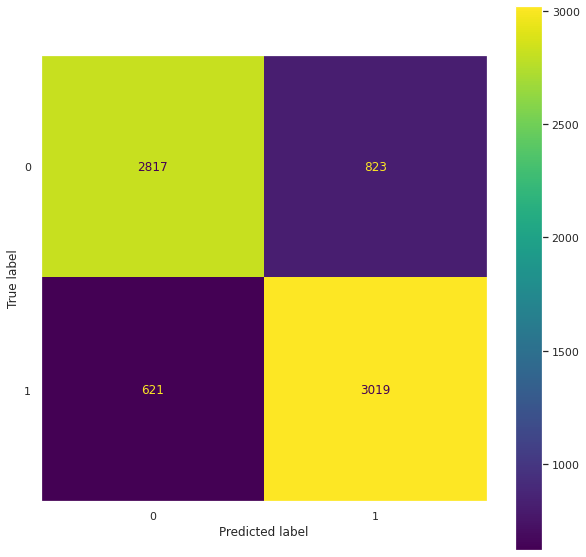

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

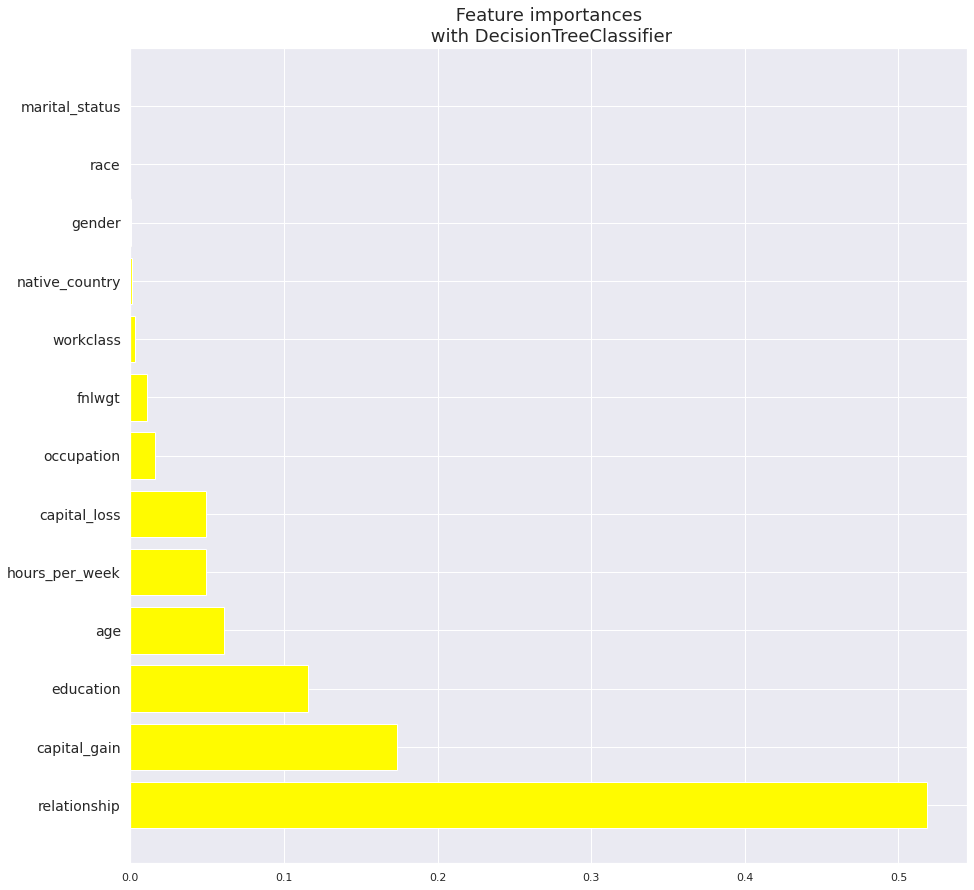

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = adult_df.drop('income', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

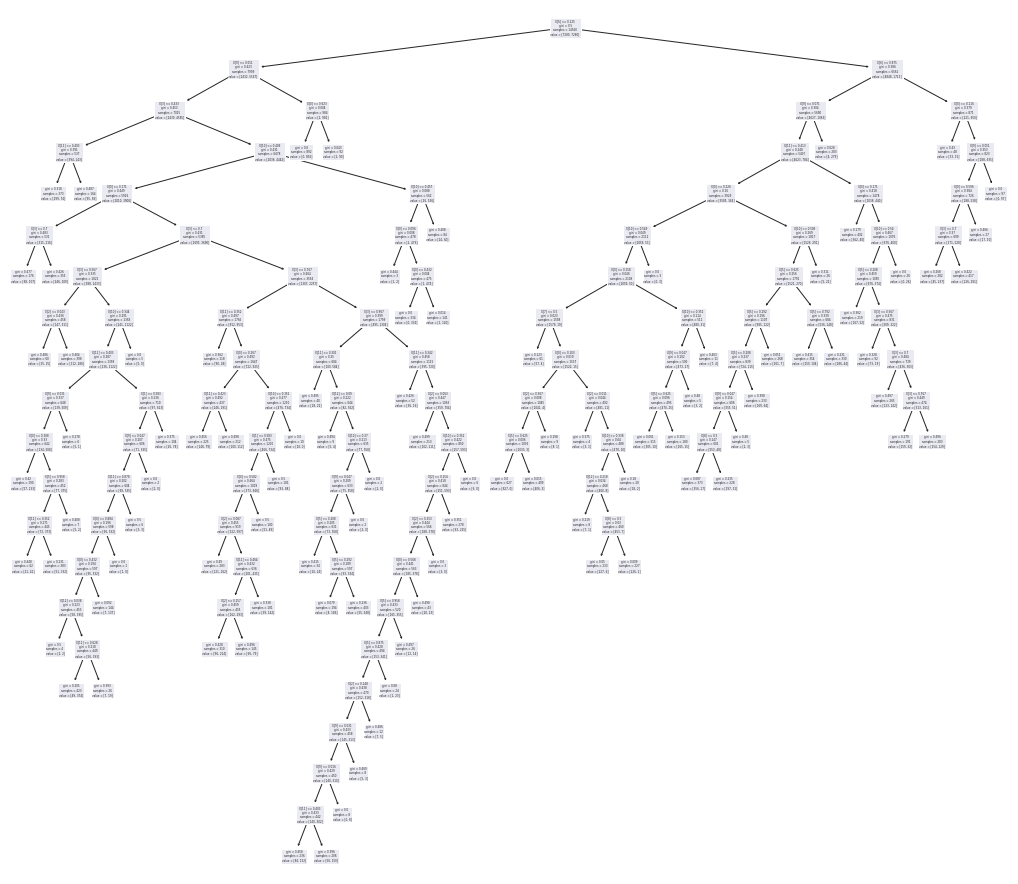

In [ ]:
plt.figure(figsize = (18, 16))
tree.plot_tree(dt_tuned)
plt.show()

In [ ]:
results = pd.DataFrame(data = x_test, columns=['race','gender','marital_status','relationship'])
results['y_test'] = y_test
results['pred'] = pred

In [ ]:
results['y_test'].replace(0, '<=50K', inplace=True)
results['y_test'].replace(1, '>50K', inplace=True)
results['pred'].replace(0, '<=50K', inplace=True)
results['pred'].replace(1, '>50K', inplace=True)
results['race'].replace(0, 'Amer_Indian_Eskimo', inplace=True)
results['race'].replace(1, 'Asian_Pac_Islander', inplace=True)
results['race'].replace(2, 'Black', inplace=True)
results['race'].replace(3, 'White', inplace=True)
results['gender'].replace(0, 'Female', inplace=True)
results['gender'].replace(1, 'Male', inplace=True)
results['marital_status'].replace(0, 'Divorced', inplace=True)
results['marital_status'].replace(1, 'Married_AF_Spouse', inplace=True)
results['marital_status'].replace(2, 'Married_Civ_Spouse', inplace=True)
results['marital_status'].replace(3, 'Married_Spouse_Absent', inplace=True)
results['marital_status'].replace(4, 'Never_Married', inplace=True)
results['marital_status'].replace(5, 'Separated', inplace=True)
results['marital_status'].replace(6, 'Widowed', inplace=True)
results['relationship'].replace(0, 'Husband', inplace=True)
results['relationship'].replace(1, 'Not_In_Family', inplace=True)
results['relationship'].replace(2, 'Own_Child', inplace=True)
results['relationship'].replace(3, 'Unmarried', inplace=True)
results['relationship'].replace(4, 'Wife', inplace=True)

results.head()

,race,gender,marital_status,relationship,y_test,pred
34912,White,Female,Never_Married,Own_Child,<=50K,<=50K
48168,White,Male,Married_Civ_Spouse,Husband,<=50K,<=50K
37792,White,Male,Married_Civ_Spouse,Husband,<=50K,<=50K
21564,White,Male,Divorced,Not_In_Family,<=50K,<=50K
11480,White,Male,Married_Civ_Spouse,Husband,<=50K,>50K


### Race Comparisons

In [ ]:
# create a dataframe of only divorced predicted and true values
race_results_am = results[results['race']=='Amer_Indian_Eskimo']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
race_results_am['true']  = np.where((race_results_am['y_test'] == race_results_am['pred']), 1, 0)
# calculate percentage of correct classifications
am_accuracy = (sum(race_results_am['true'])/race_results_am.shape[0])*100
am_accuracy

80.95238095238095

In [ ]:
# create a dataframe of only married predicted and true values
race_results_as = results[results['race']=='Asian_Pac_Islander']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
race_results_as['true']  = np.where((race_results_as['y_test'] == race_results_as['pred']), 1, 0)
# calculate percentage of correct classifications
as_accuracy = (sum(race_results_as['true'])/race_results_as.shape[0])*100
as_accuracy

76.0

In [ ]:
# create a dataframe of only single predicted and true values
race_results_bl = results[results['race']=='Black']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
race_results_bl['true']  = np.where((race_results_bl['y_test'] == race_results_bl['pred']), 1, 0)
# calculate percentage of correct classifications
bl_accuracy = (sum(race_results_bl['true'])/race_results_bl.shape[0])*100
bl_accuracy

84.76190476190476

In [ ]:
# create a dataframe of only single predicted and true values
race_results_wh = results[results['race']=='White']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
race_results_wh['true']  = np.where((race_results_wh['y_test'] == race_results_wh['pred']), 1, 0)
# calculate percentage of correct classifications
wh_accuracy = (sum(race_results_wh['true'])/race_results_wh.shape[0])*100
wh_accuracy

79.91373998767715

### Gender Comparisons

In [ ]:
# create a dataframe of only female predicted and true values
gender_results_fe = results[results['gender']=='Female']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
gender_results_fe['true']  = np.where((gender_results_fe['y_test'] == gender_results_fe['pred']), 1, 0)
# calculate percentage of correct classifications
fe_accuracy = (sum(gender_results_fe['true'])/gender_results_fe.shape[0])*100
fe_accuracy

85.58315334773218

In [ ]:
# create a dataframe of only male predicted and true values
gender_results_ma = results[results['gender']=='Male']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
gender_results_ma['true']  = np.where((gender_results_ma['y_test'] == gender_results_ma['pred']), 1, 0)
# calculate percentage of correct classifications
ma_accuracy = (sum(gender_results_ma['true'])/gender_results_ma.shape[0])*100
ma_accuracy

78.31613854089903

### Marital Comparisons

In [ ]:
# create a dataframe of only female predicted and true values
marital_results_di = results[results['marital_status']=='Divorced']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_di['true']  = np.where((marital_results_di['y_test'] == marital_results_di['pred']), 1, 0)
# calculate percentage of correct classifications
di_accuracy = (sum(marital_results_di['true'])/marital_results_di.shape[0])*100
di_accuracy

83.22580645161291

In [ ]:
# create a dataframe of only male predicted and true values
#marital_results_af = results[results['marital_status']=='Married_AF_Spouse']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
#marital_results_af['true']  = np.where((marital_results_af['y_test'] == marital_results_af['pred']), 1, 0)
# calculate percentage of correct classifications
#af_accuracy = (sum(marital_results_af['true'])/marital_results_af.shape[0])*100
#af_accuracy

In [ ]:
# create a dataframe of only male predicted and true values
marital_results_ci = results[results['marital_status']=='Married_Civ_Spouse']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_ci['true']  = np.where((marital_results_ci['y_test'] == marital_results_ci['pred']), 1, 0)
# calculate percentage of correct classifications
ci_accuracy = (sum(marital_results_ci['true'])/marital_results_ci.shape[0])*100
ci_accuracy

75.82049564634963

In [ ]:
# create a dataframe of only male predicted and true values
marital_results_ab = results[results['marital_status']=='Married_Spouse_Absent']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_ab['true']  = np.where((marital_results_ab['y_test'] == marital_results_ab['pred']), 1, 0)
# calculate percentage of correct classifications
ab_accuracy = (sum(marital_results_ab['true'])/marital_results_ab.shape[0])*100
ab_accuracy

85.29411764705883

In [ ]:
# create a dataframe of only male predicted and true values
marital_results_nm = results[results['marital_status']=='Never_Married']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_nm['true']  = np.where((marital_results_nm['y_test'] == marital_results_nm['pred']), 1, 0)
# calculate percentage of correct classifications
nm_accuracy = (sum(marital_results_nm['true'])/marital_results_nm.shape[0])*100
nm_accuracy

89.70406905055486

In [ ]:
# create a dataframe of only male predicted and true values
marital_results_se = results[results['marital_status']=='Separated']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_se['true']  = np.where((marital_results_se['y_test'] == marital_results_se['pred']), 1, 0)
# calculate percentage of correct classifications
se_accuracy = (sum(marital_results_se['true'])/marital_results_se.shape[0])*100
se_accuracy

84.15300546448088

In [ ]:
# create a dataframe of only male predicted and true values
marital_results_wi = results[results['marital_status']=='Widowed']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_wi['true']  = np.where((marital_results_wi['y_test'] == marital_results_wi['pred']), 1, 0)
# calculate percentage of correct classifications
wi_accuracy = (sum(marital_results_wi['true'])/marital_results_wi.shape[0])*100
wi_accuracy

82.99319727891157

### Relationship Comparisons

In [ ]:
# create a dataframe of only Husband predicted and true values
relationship_results_hu = results[results['relationship']=='Husband']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
relationship_results_hu['true']  = np.where((relationship_results_hu['y_test'] == relationship_results_hu['pred']), 1, 0)
# calculate percentage of correct classifications
hu_accuracy = (sum(relationship_results_hu['true'])/relationship_results_hu.shape[0])*100
hu_accuracy

76.21769383697813

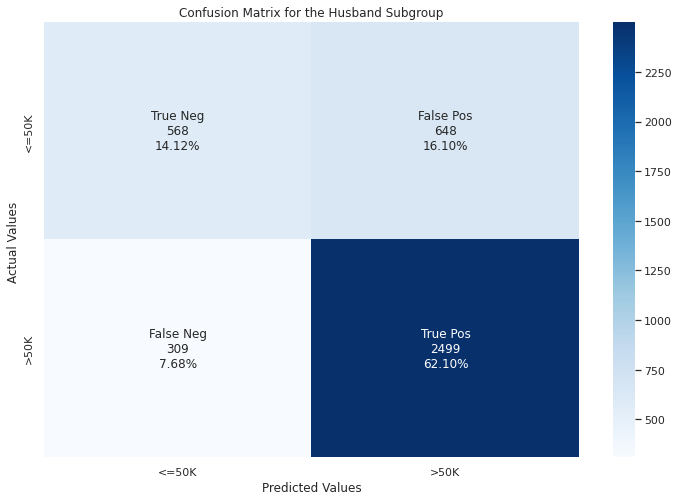

In [ ]:
# a confusion matrix of one of the subgroups in the protected category
y_test = relationship_results_hu['y_test']
pred = relationship_results_hu['pred']
asi_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                asi_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     asi_cf.flatten()/np.sum(asi_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(asi_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Husband Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['<=50K','>50K'])
ax.yaxis.set_ticklabels(['<=50K','>50K'])

plt.show()

In [ ]:
# create a dataframe of only Not In Family predicted and true values
relationship_results_no = results[results['relationship']=='Not_In_Family']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
relationship_results_no['true']  = np.where((relationship_results_no['y_test'] == relationship_results_no['pred']), 1, 0)
# calculate percentage of correct classifications
no_accuracy = (sum(relationship_results_no['true'])/relationship_results_no.shape[0])*100
no_accuracy

81.8297331639136

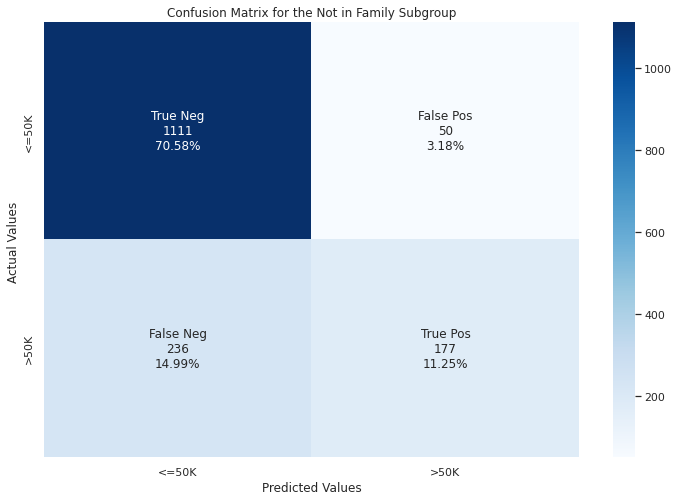

In [ ]:
# a confusion matrix of one of the subgroups in the protected category
y_test = relationship_results_no['y_test']
pred = relationship_results_no['pred']
asi_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                asi_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     asi_cf.flatten()/np.sum(asi_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(asi_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Not in Family Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['<=50K','>50K'])
ax.yaxis.set_ticklabels(['<=50K','>50K'])

plt.show()

In [ ]:
# create a dataframe of only Own Child predicted and true values
relationship_results_ow = results[results['relationship']=='Own_Child']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
relationship_results_ow['true']  = np.where((relationship_results_ow['y_test'] == relationship_results_ow['pred']), 1, 0)
# calculate percentage of correct classifications
ow_accuracy = (sum(relationship_results_ow['true'])/relationship_results_ow.shape[0])*100
ow_accuracy

97.57834757834758

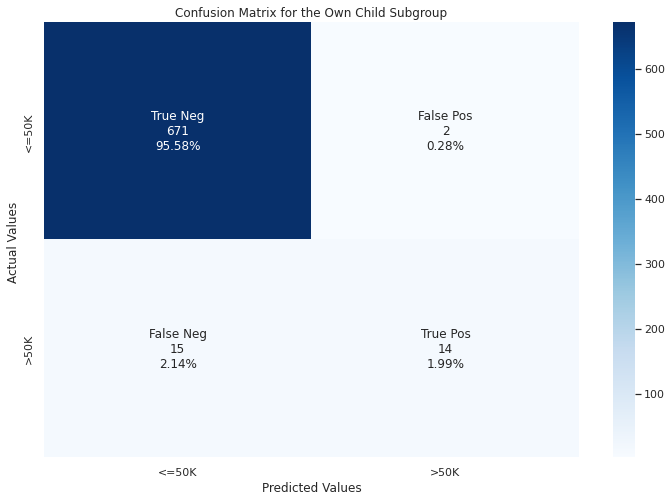

In [ ]:
# a confusion matrix of one of the subgroups in the protected category
y_test = relationship_results_ow['y_test']
pred = relationship_results_ow['pred']
asi_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                asi_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     asi_cf.flatten()/np.sum(asi_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(asi_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Own Child Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['<=50K','>50K'])
ax.yaxis.set_ticklabels(['<=50K','>50K'])

plt.show()

In [ ]:
# create a dataframe of only Unmarried predicted and true values
relationship_results_un = results[results['relationship']=='Unmarried']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
relationship_results_un['true']  = np.where((relationship_results_un['y_test'] == relationship_results_un['pred']), 1, 0)
# calculate percentage of correct classifications
un_accuracy = (sum(relationship_results_un['true'])/relationship_results_un.shape[0])*100
un_accuracy

88.76611418047882

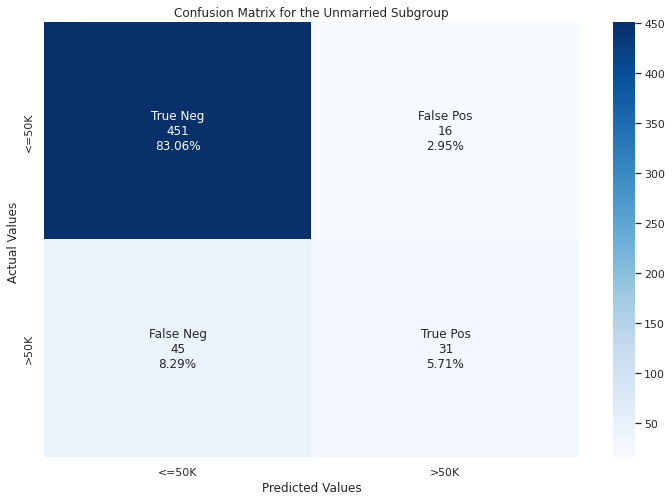

In [ ]:
# a confusion matrix of one of the subgroups in the protected category
y_test = relationship_results_un['y_test']
pred = relationship_results_un['pred']
asi_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                asi_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     asi_cf.flatten()/np.sum(asi_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(asi_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Unmarried Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['<=50K','>50K'])
ax.yaxis.set_ticklabels(['<=50K','>50K'])

plt.show()

In [ ]:
# create a dataframe of only Wife predicted and true values
relationship_results_wi = results[results['relationship']=='Wife']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
relationship_results_wi['true']  = np.where((relationship_results_wi['y_test'] == relationship_results_wi['pred']), 1, 0)
# calculate percentage of correct classifications
wi_accuracy = (sum(relationship_results_wi['true'])/relationship_results_wi.shape[0])*100
wi_accuracy

71.85354691075516

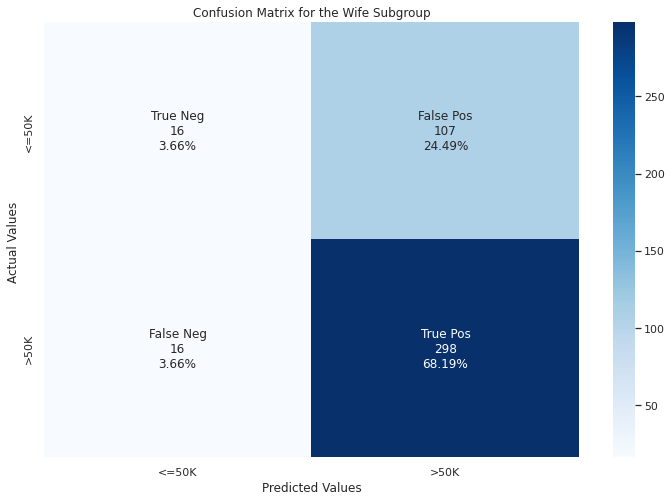

In [ ]:
# a confusion matrix of one of the subgroups in the protected category
y_test = relationship_results_wi['y_test']
pred = relationship_results_wi['pred']
asi_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                asi_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     asi_cf.flatten()/np.sum(asi_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(asi_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Wife Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['<=50K','>50K'])
ax.yaxis.set_ticklabels(['<=50K','>50K'])

plt.show()

### Comparison Tables

In [ ]:
from tabulate import tabulate
data = [['American Indian Eskimo', am_accuracy],
['Asian Pacific Islander', as_accuracy],
['Black', bl_accuracy],
['White', wh_accuracy]
]
print (tabulate(data, headers=["Race", "Classification Accuracy"]))

Race                      Classification Accuracy
----------------------  -------------------------
American Indian Eskimo                    80.9524
Asian Pacific Islander                    76
Black                                     84.7619
White                                     79.9137


In [ ]:
from tabulate import tabulate
data = [['Female', fe_accuracy],
['Male', ma_accuracy]]
print (tabulate(data, headers=["Gender", "Classification Accuracy"]))

Gender      Classification Accuracy
--------  -------------------------
Female                      85.5832
Male                        78.3161


In [ ]:
from tabulate import tabulate
data = [['Divorced', di_accuracy],
#['Married_AF_Spouse', af_accuracy],
['Married_Civ_Spouse', ci_accuracy],
['Married_Spouse_Absent', ab_accuracy],
['Never_Married', nm_accuracy],
['Separated', se_accuracy],
['Widowed', wi_accuracy]]
print (tabulate(data, headers=["Marital Status", "Classification Accuracy"]))

Marital Status           Classification Accuracy
---------------------  -------------------------
Divorced                                 83.2258
Married_Civ_Spouse                       75.8205
Married_Spouse_Absent                    85.2941
Never_Married                            89.7041
Separated                                84.153
Widowed                                  71.8535


In [ ]:
from tabulate import tabulate
data = [['Husband', hu_accuracy],
['Not_In_Family', no_accuracy],
['Own_Child', ow_accuracy],
['Unmarried', un_accuracy],
['Wife', wi_accuracy]]
print (tabulate(data, headers=["Relationship", "Classification Accuracy"]))

Relationship      Classification Accuracy
--------------  -------------------------
Husband                           76.2177
Not_In_Family                     81.8297
Own_Child                         97.5783
Unmarried                         88.7661
Wife                              71.8535
